# BigQuery Commands

Google Cloud Datalab provides a first class experience for working with Google BigQuery for both adhoc, exploratory work as well as pipeline development. In addition to authoring and executing SQL queries, you'll likely want to inspect DataSets, Tables, and their Schema, and also sample data.

This notebook introduces various BigQuery commands that Cloud Datalab brings into the notebook environment.

You've already seen a BigQuery command in the [Hello BigQuery](Hello BigQuery.ipynb) notebook, they are invoked using `%%bq`.

## Commands, literally

You can think of `%%bq` as your command line interface to BigQuery. These commands take arguments, including `--help` (or `-h`), in the same manner as other shell commands. Lets start by looking at help.

In [1]:
%bq --help

usage: bq [-h]
          {datasets,tables,query,execute,extract,sample,dryrun,udf,datasource,load}
          ...

Execute various BigQuery-related operations. Use "%bq <command> -h" for help
on a specific command.

positional arguments:
  {datasets,tables,query,execute,extract,sample,dryrun,udf,datasource,load}
                        commands
    datasets            Operations on BigQuery datasets
    tables              Operations on BigQuery tables
    query               Create a BigQuery SQL query object, optionally using
                        other SQL objects, UDFs, or external datasources.
    execute             Execute a BigQuery SQL query and optionally send the
                        results to a named table. The cell can optionally
                        contain arguments for expanding variables in the
                        query.
    extract             Extract a query or table into file (local or GCS)
    sample              Display a sample of the results of a Big

You can get help on any of the individual commands as follows:

In [2]:
%bq tables --help

usage: bq tables [-h] {list,create,describe,delete,view} ...

Operations on BigQuery tables

positional arguments:
  {list,create,describe,delete,view}
    list                List the tables in a BigQuery project or dataset.
    create              Create a table.
    describe            View a table's schema
    delete              Delete a table.
    view                View a table.

optional arguments:
  -h, --help            show this help message and exit
None


# Listing BigQuery Resources

The first thing you might decide to do is list datasets and tables contained within a specified project or the default project you're running this Cloud Datalab environment in.

Note that you will be able to list and use any BigQuery dataset that has been shared with the project (its service account) that you are running Cloud Datalab in.

In [ ]:
%bq datasets list --project cloud-datalab-samples

In [4]:
%bq tables list --dataset cloud-datalab-samples.httplogs

# Exploring Data

Once you've found a table or set of tables to work with, its simple to retrieve its schema or some sampling of rows to understand the data you're working with.

## Schema

In [5]:
%bq tables describe --name cloud-datalab-samples.httplogs.logs_20140615

## Sample Data

In [6]:
%bq sample --help

usage: bq sample [-h] [-q QUERY | -t TABLE | -v VIEW] [-nc]
                 [-d {legacy,standard}] [-b BILLING]
                 [-m {limit,random,hashed,sorted}] [--fields FIELDS]
                 [-c COUNT] [-p PERCENT] [--key-field KEY_FIELD]
                 [-o {ascending,descending}] [-P] [--verbose]

Display a sample of the results of a BigQuery SQL query. The cell can
optionally contain arguments for expanding variables in the query, if
-q/--query was used, or it can contain SQL for a query.

optional arguments:
  -h, --help            show this help message and exit
  -q QUERY, --query QUERY
                        the name of the query object to sample
  -t TABLE, --table TABLE
                        the name of the table object to sample
  -v VIEW, --view VIEW  the name of the view object to sample
  -nc, --nocache        Don't use previously cached results
  -d {legacy,standard}, --dialect {legacy,standard}
                        BigQuery SQL dialect
  -b BILLING, --bill

As you can see, Cloud Datalab allows you to sample a specified count of rows using various sampling strategies, including random sampling or hashing. Let's try retrieving a couple of samples.

In [7]:
%bq sample --table cloud-datalab-samples.httplogs.logs_20140615 --count 5

timestamp,latency,status,method,endpoint
2014-06-15 07:00:00.536486,48,200,GET,Interact3
2014-06-15 07:00:00.003772,122,200,GET,Interact3
2014-06-15 07:00:00.670100,103,200,GET,Interact3
2014-06-15 07:00:00.428897,144,200,GET,Interact3
2014-06-15 07:00:00.652760,28,405,GET,Interact2


You can also specify a list of fields to project.

In [8]:
%bq sample --table cloud-datalab-samples.httplogs.logs_20140615 --count 10 --fields timestamp,latency --method hashed --key-field latency

timestamp,latency
2014-06-15 07:00:01.750207,26
2014-06-15 07:00:01.166912,27
2014-06-15 07:00:00.652760,28
2014-06-15 07:00:00.943075,28
2014-06-15 07:00:01.694210,29
2014-06-15 07:00:01.735101,37
2014-06-15 07:00:00.536486,48
2014-06-15 07:00:01.456010,123
2014-06-15 07:00:01.000102,124
2014-06-15 07:00:00.428897,144


# Querying Data

Of course, since, querying BigQuery data using SQL is the primary scenario, it's always handy to have the BigQuery SQL reference. Datalab makes this easy to access by providing a direct link to the [query reference](https://cloud.google.com/bigquery/query-reference) via the Help button on the top toolbar.

Lets see some more query examples.

In [14]:
%%bq query --name log_query
SELECT timestamp, latency
FROM `cloud-datalab-samples.httplogs.logs_20140615`
ORDER BY latency DESC
LIMIT 10

In [15]:
%bq execute -q log_query

timestamp,latency
2014-06-15 10:15:06.354093,13500918
2014-06-15 09:15:04.571911,13500391
2014-06-15 10:00:05.264877,13500340
2014-06-15 09:45:04.873233,13500166
2014-06-15 09:30:07.401665,13500118
2014-06-16 00:01:45.311564,1197339
2014-06-15 15:17:12.987435,136467
2014-06-15 15:16:33.290520,130296
2014-06-15 15:15:56.727494,121277
2014-06-15 15:15:58.259215,97192


That was a simple query. Now, let's do something a bit more interesting: let's compute the 50th percentile, 95th percentile, and 99th percentile latencies for request processing.

BigQuery makes this effortless with its built-in statistical and analytics functions, such as `QUANTILES`.

In [10]:
%%bq query --name quantiles_query
SELECT
  quantiles[SAFE_ORDINAL(50)] AS latency_50th_percentile,
  quantiles[SAFE_ORDINAL(95)] AS latency_95th_percentile,
  quantiles[SAFE_ORDINAL(99)] AS latency_99th_percentile
FROM (
  SELECT APPROX_QUANTILES(latency, 100) AS quantiles
  FROM `cloud-datalab-samples.httplogs.logs_20140615`
)

In [11]:
%bq execute -q quantiles_query

latency_50th_percentile,latency_95th_percentile,latency_99th_percentile
81,418,5047


# Visualizing Data

Beyond tables, it almost always interesting to be able to visualize the data to get a more meaningful view of aggregates, trends and patterns.

Let's write another query, also using `QUANTILES`. This time, the `ROW_NUMBER` function will be used to also include a row number in the output data representing the percentile, using the number as the chart's x-axis value. In order to reference this SQL query in the chart, it is converted into a SQL module via the `--module` argument. This module can then be passed to the chart by referencing its name. The chart will execute the contained query.

In [12]:
%%bq query --name data
WITH quantiles AS (
  SELECT APPROX_QUANTILES(LOG10(latency), 50) AS timearray
  FROM `cloud-datalab-samples.httplogs.logs_20140615`
  WHERE latency <> 0
)
select row_number() over(order by time) as percentile, time from quantiles cross join unnest(quantiles.timearray) as time
order by percentile

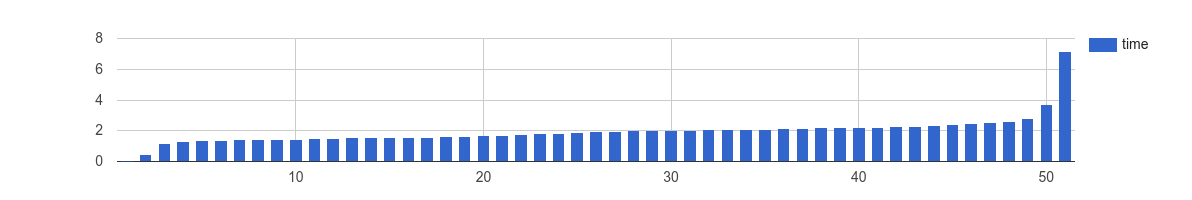

In [36]:
%chart columns --data data --fields percentile,time

# Looking Ahead

There are other commands, such as those that import (load) and export (extract) data or that handle tables and datasets.

Datalab allows creating **parameterized queries**, which can be modified using variables defined interactively in the notebook. Queries can be declared one step at a time to create **composite SQL queries** that use different constructs such as User Defined Functions and external data sources, in order to harness the full power of BigQuery SQL while managing authoring complexity.

All of these BigQuery commands are implemented on top of **Python BigQuery APIs** (in the `google.datalab.bigquery` Python module). This implementation not only allows you to write arbitrary code and logic while working with BigQuery data, but also lets you integrate SQL and Python, and the Python data analysis libraries such as pandas and matplotlib, to perform sophisticated and custom data analysis and visualization tasks.

These topics are covered in other BigQuery tutorial notebooks that are included with Cloud Datalab.